<a href="https://colab.research.google.com/github/nicostanw/NLP_Toxic_Comment_Classification/blob/main/NLP_Project_Dimanche_presque_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import re
import string 
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/NLP project

/content/drive/MyDrive/NLP project


In [7]:
train = pd.read_csv('train.csv', sep=',')
print(train.shape)

(159571, 8)


In [8]:
train.head(15)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [9]:
tokenizer = get_tokenizer('basic_english')

#Tokenization, on réduit les phrases en bouts simples

def clean_text(text):
  text=text.lower()  #Met en minuscules
  url_pattern = re.compile(r'https?://\S+|www\.\S+')   #Enleve les liens 
  text=url_pattern.sub(r'', text)
  text=re.sub(r'\d+', '',text)    #Enleve les nbs
  translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))    #Enleve poncutation 
  text=text.translate(translator)
  text=re.sub(r'\n',' ',text)   #enleve les /n
  text= re.sub(' +', ' ', text)    #enleve les trop grands espaces 
  return(text.strip())   #Clean les bords

In [10]:
X=train["comment_text"].apply(clean_text)
X.head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

In [11]:
y=train[train.columns[2:]].apply(lambda x:np.array(list(x)),axis=1)
print(y) 
print(len(y))
num_class=y[0].size
print(num_class)
print(y.sum())

0         [0, 0, 0, 0, 0, 0]
1         [0, 0, 0, 0, 0, 0]
2         [0, 0, 0, 0, 0, 0]
3         [0, 0, 0, 0, 0, 0]
4         [0, 0, 0, 0, 0, 0]
                 ...        
159566    [0, 0, 0, 0, 0, 0]
159567    [0, 0, 0, 0, 0, 0]
159568    [0, 0, 0, 0, 0, 0]
159569    [0, 0, 0, 0, 0, 0]
159570    [0, 0, 0, 0, 0, 0]
Length: 159571, dtype: object
159571
6
[15294  1595  8449   478  7877  1405]


In [12]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for text in X:
  counter.update(tokenizer(text))
vocab = Vocab(counter, min_freq=3)   #Le vocab qui apparait au moins 3 fois

In [13]:
vocab_size=len(vocab)
print(vocab_size)  #En tout on a 59 868 mots qui apparaissent au moins 3 fois

59868


In [14]:
max_len=X.map(lambda x:len(tokenizer(x))).max()    #Le plus long texte
print(max_len)

1403


In [15]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class ToxicCommentDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X,y):

        self.X =X
        self.y =y
        

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
       
        return (self.X.iloc[idx],self.y.iloc[idx])


def collate_batch(batch):
    vectorized_seqs=[]
    list_label=[]
    for text , label in batch:
      vectorized_seqs.append(text_pipeline(text))
      list_label.append(label)
      
    seq_lengths=list(map(len, vectorized_seqs))
    seq_tensor=torch.ones(size=(len(batch),max_len),dtype=torch.int64)
    for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
      seq_tensor[idx, :seqlen] = torch.tensor(seq,dtype=torch.int64)
    
        
    return seq_tensor.to(device),torch.tensor(list_label,dtype=torch.int64).to(device)

In [57]:
from torch import nn
from torch import autograd
from torch.nn import functional as F
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim,hidden_dim, num_class):
        super(TextClassificationModel, self).__init__()
      
        self.hidden_dim=hidden_dim

        self.embedding = nn.Embedding(vocab_size,embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*hidden_dim,num_class)
       # self.hidden = self.init_hidden()

    '''def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),   
                autograd.Variable(torch.zeros(2, self.batch_size, self.hidden_dim))) '''

    def forward(self, text):
        embed_text= self.embedding(text)
        _,(hn,_) = self.lstm(embed_text)
        x=torch.cat((hn[0,:,:],hn[1,:,:]),1)
        x=self.drop(x)
      
        return torch.sigmoid(self.fc(x))

In [20]:
toxic_train=ToxicCommentDataset(X_train,y_train)
dataloaders = DataLoader(toxic_train, batch_size=8, shuffle=False,collate_fn=collate_batch)
print(dataloaders)

criterion1 = nn.BCELoss()
criterion2 = nn.CrossEntropyLoss()

for i,(u,l) in enumerate(dataloaders):
  
  outputs = model(u)
  preds2=torch.where(outputs<0.5,0,1).float()
  #print((preds2==l).float().mean(axis=1).mean())
  print((preds2==l).float())
  print((preds2==l))
  print(l,preds2)
  loss=0
  if i==0:
    break


tensor([[1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1.]], device='cuda:0')
tensor([[ True, False, False,  True,  True, False],
        [ True, False,  True, False,  True, False],
        [ True, False, False, False, False, False],
        [ True, False, False, False,  True,  True],
        [False, False, False,  True, False,  True],
        [ True, False, False, False,  True, False],
        [False,  True,  True, False, False, False],
        [False, False, False, False,  True,  True]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0]], device='cuda:0') tensor([[0., 1., 1., 0., 0., 1.],


In [ ]:
x=np.arange(40).reshape(2,2,10)
print(x.shape)
print(x[0,:,:],x[1,:,:])
print(np.concatenate((x[0,:,:],x[1,:,:]),axis=1).shape)

(2, 2, 10)
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]] [[20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
(2, 20)


In [54]:
from __future__ import print_function
from __future__ import division
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from tqdm import tqdm
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
from numba import cuda
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

import tqdm.notebook as tq

In [58]:
#Now we set our training function 
def train_model(model,X,y, optimizer, batch_size=10,num_epochs=9):
    
    X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=5,test_size=0.2)
    toxic_train=ToxicCommentDataset(X_train,y_train)
    trainloader = DataLoader(ToxicCommentDataset(X_train,y_train), batch_size=batch_size, shuffle=True,collate_fn=collate_batch)
    valloader   = DataLoader(ToxicCommentDataset(X_val,y_val), batch_size=1000, shuffle=True,collate_fn=collate_batch)
    criterion=nn.BCELoss(reduction='sum')
    since = time.time()
    loss_val_history=[]
    map_history=[]
    best_map = 0.0
    print("u")
    for epoch in range(1,num_epochs+1):
        
        running_train_loss = 0.0
        best_model_wts = copy.deepcopy(model.state_dict())
        
        
        model.train()
        # Iterate over data.
        for j,(inputs, labels) in tq.tqdm(enumerate(trainloader)):
        
                # zero the parameter gradients
                optimizer.zero_grad()
              
                # forward
                # track history if only in train
                outputs = model(inputs)
                
                loss = criterion(outputs, labels.float())
                
                      #running_corrects += torch.sum(preds == labels.data[:,z])
                    # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
          
                running_train_loss += loss.item()
             
                if j%364==0:
                  model.eval()  
                  map=0 
                  i=0
                  running_val_loss = 0.0
                  with torch.no_grad():   
                    for val_inp,val_lab in valloader:
                  
                      val_out = model(val_inp)
                      loss = criterion(val_out, val_lab.float())
                      running_val_loss += loss.item() 
                      preds=torch.where(val_out<0.5,0,1)
            
                      map+=(preds==val_lab).float().mean()
                      i+=1
                  runnig_val_loss=running_val_loss/(len(valloader.dataset)*num_class)
                  map=map/i
                  loss_val_history.append(running_val_loss)
                  map_history.append(map)
                  print(f"Epoch[{epoch}/{num_epochs}],batch[{j+1}/{len(trainloader.dataset)//batch_size}]: val_loss={running_val_loss:.3f}",
                        f"mean average precision={map:.3f}")
                  if map>best_map:
                    best_model_wts = copy.deepcopy(model.state_dict())

                  model.train()
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
    return model,loss_val_history,map_history
    

    


In [20]:
batch_size=50
_,_,y_t,_=train_test_split(X,y,random_state=5,test_size=0.2)
(((y_t.size)//batch_size)-1)//7

364

In [59]:
batch_size=50
model=TextClassificationModel(vocab_size,100,100,num_class).to(device)
optimizer=optim.Adam(model.parameters(),lr=1e-3)

In [60]:
model,loss_val_history,map_history=train_model(model,X,y, optimizer, batch_size=50,num_epochs=5)

u


Epoch[1/5],batch[1/2553]: val_loss=130611.868 mean average precision=0.661
Epoch[1/5],batch[365/2553]: val_loss=18762.163 mean average precision=0.969
Epoch[1/5],batch[729/2553]: val_loss=14826.160 mean average precision=0.973
Epoch[1/5],batch[1093/2553]: val_loss=13776.927 mean average precision=0.978
Epoch[1/5],batch[1457/2553]: val_loss=12832.818 mean average precision=0.979
Epoch[1/5],batch[1821/2553]: val_loss=11977.524 mean average precision=0.980
Epoch[1/5],batch[2185/2553]: val_loss=11566.789 mean average precision=0.980
Epoch[1/5],batch[2549/2553]: val_loss=11085.575 mean average precision=0.981



Epoch[2/5],batch[1/2553]: val_loss=11292.344 mean average precision=0.980
Epoch[2/5],batch[365/2553]: val_loss=10619.511 mean average precision=0.981
Epoch[2/5],batch[729/2553]: val_loss=10386.494 mean average precision=0.981
Epoch[2/5],batch[1093/2553]: val_loss=10117.690 mean average precision=0.981
Epoch[2/5],batch[1457/2553]: val_loss=10163.481 mean average precision=0.982
Epoch[2/5],batch[1821/2553]: val_loss=10045.670 mean average precision=0.982
Epoch[2/5],batch[2185/2553]: val_loss=9669.307 mean average precision=0.982
Epoch[2/5],batch[2549/2553]: val_loss=9681.589 mean average precision=0.982



Epoch[3/5],batch[1/2553]: val_loss=9741.610 mean average precision=0.982
Epoch[3/5],batch[365/2553]: val_loss=9615.021 mean average precision=0.982
Epoch[3/5],batch[729/2553]: val_loss=10159.976 mean average precision=0.981
Epoch[3/5],batch[1093/2553]: val_loss=10490.546 mean average precision=0.982
Epoch[3/5],batch[1457/2553]: val_loss=9453.929 mean average precision=0.982
Epoch[3/5],batch[1821/2553]: val_loss=9218.692 mean average precision=0.982
Epoch[3/5],batch[2185/2553]: val_loss=9092.253 mean average precision=0.983
Epoch[3/5],batch[2549/2553]: val_loss=9255.093 mean average precision=0.982



Epoch[4/5],batch[1/2553]: val_loss=9220.517 mean average precision=0.982
Epoch[4/5],batch[365/2553]: val_loss=9463.718 mean average precision=0.983
Epoch[4/5],batch[729/2553]: val_loss=9101.944 mean average precision=0.983
Epoch[4/5],batch[1093/2553]: val_loss=9217.885 mean average precision=0.983
Epoch[4/5],batch[1457/2553]: val_loss=9013.384 mean average precision=0.983
Epoch[4/5],batch[1821/2553]: val_loss=8906.277 mean average precision=0.983
Epoch[4/5],batch[2185/2553]: val_loss=8800.966 mean average precision=0.983
Epoch[4/5],batch[2549/2553]: val_loss=8874.241 mean average precision=0.983



Epoch[5/5],batch[1/2553]: val_loss=8927.217 mean average precision=0.983
Epoch[5/5],batch[365/2553]: val_loss=10039.961 mean average precision=0.982
Epoch[5/5],batch[729/2553]: val_loss=9469.250 mean average precision=0.982
Epoch[5/5],batch[1093/2553]: val_loss=9035.736 mean average precision=0.982
Epoch[5/5],batch[1457/2553]: val_loss=9536.018 mean average precision=0.983
Epoch[5/5],batch[1821/2553]: val_loss=9237.556 mean average precision=0.983
Epoch[5/5],batch[2185/2553]: val_loss=9014.046 mean average precision=0.983
Epoch[5/5],batch[2549/2553]: val_loss=8842.807 mean average precision=0.983

Training complete in 25m 15s


In [27]:
import matplotlib.pyplot as plt


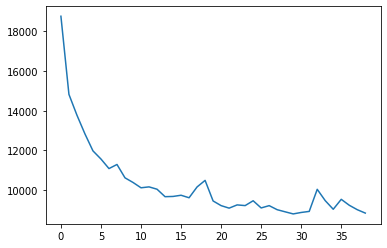

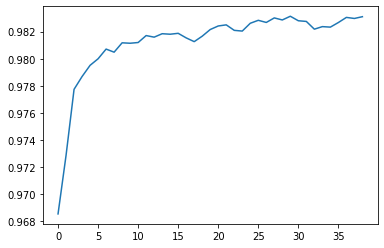

In [61]:
plt.figure()
plt.plot(loss_val_history[1:])
plt.figure()
plt.plot(map_history[1:])